In [3]:
# we define a simformer using our SDE model

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append('./src')
sys.path.append('./reference/simformer-main/src/probjax')
sys.path.append('./reference/simformer-main/src/scoresbibm')

sys.path.append('../src')
sys.path.append('../reference/simformer-main/src/probjax')
sys.path.append('../reference/simformer-main/src/scoresbibm')

import os
# os.environ['JAX_PLATFORMS']="cpu"

import jax 
import jax.numpy as jnp
import numpy as np

import haiku as hk

# import torch

import matplotlib.pyplot as plt

# from scoresbibm.tasks import get_task
# from scoresbibm.methods.score_transformer import run_train_transformer_model
# from scoresbibm.methods.neural_nets import scalar_transformer_model
from scoresbibm.methods.sde import init_sde_related
# from scoresbibm.utils.plot import use_style

from tqdm.auto import tqdm

In [6]:
import diffusion
from diffusion.sbi.transformer import Transformer
from diffusion.embedding import GaussianFourierEmbedding, SinusoidalEmbedding
from diffusion import sde as sde_ours

In [7]:
print(jax.default_backend())
print(jax.devices())

gpu
[CudaDevice(id=0)]


In [8]:
train=True

# generate dataset

In [9]:
# we have two parameters, theta1 and theta2
# we have two outputs, y1 and y2, corresponding to the measurement with two different detectors

npoints = 2**10 #1024

nobs = 128_000
wavefun = lambda theta1, theta2, x: jnp.sin(theta1*x)*jnp.cos(theta2*x)


rng = jax.random.PRNGKey(42)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
thetas = jax.random.normal(key, (nobs,2))+0.5
noise1 = jax.random.normal(key, (nobs,npoints))*0.3
noise2 = jax.random.normal(key, (nobs,npoints))*0.3

xs1 = wavefun(thetas[:,0:1], thetas[:,1:2],x1) + noise1
xs2 = wavefun(thetas[:,0:1], thetas[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs = jnp.concatenate([xs1,xs2],axis=1)


In [10]:
xs.shape, thetas.shape

((128000, 2, 1024), (128000, 2))

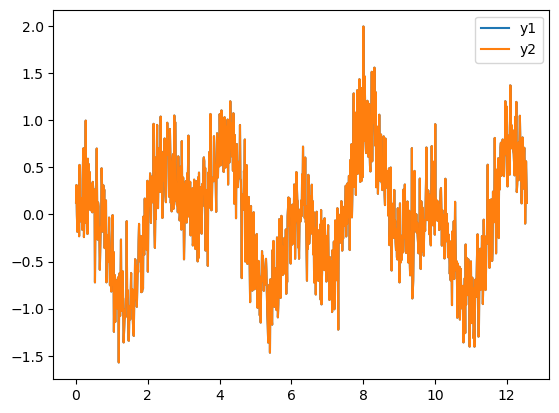

In [11]:
i=5
plt.plot(x1[0,:], xs1[i,0,:], label='y1')
plt.plot(x2[0,:], xs2[i,0,:], label='y2')
plt.legend()
plt.show()

# data preprocessing

In [12]:
# thetas = jax.device_put(thetas, jax.devices("cpu")[0])
# xs = jax.device_put(xs, jax.devices("cpu")[0])

In [13]:
thetas_mean = jnp.mean(thetas, axis=0, keepdims=True)
thetas_std = jnp.std(thetas, axis=0, keepdims=True)

thetas = (thetas - thetas_mean) / thetas_std

In [14]:
def z_score_thetas(thetas):
    thetas = (thetas - thetas_mean) / thetas_std
    return thetas

def un_z_score_thetas(thetas):
    thetas = thetas * thetas_std + thetas_mean
    return thetas

In [15]:
xs_mean = jnp.mean(xs, axis=0, keepdims=True)
xs_mean = jnp.mean(xs_mean, axis=-1, keepdims=True)
xs_std = jnp.std(xs, axis=0, keepdims=True)
xs_std = jnp.std(xs_std, axis=-1, keepdims=True)

xs = (xs - xs_mean) / xs_std

In [16]:
def z_score_xs(xs):
    xs = (xs - xs_mean) / xs_std
    return xs

def un_z_score_xs(xs):
    xs = xs * xs_std + xs_mean
    return xs

In [17]:
def ravel(data, axis=-1):
    flat_data, tree = jax.tree_util.tree_flatten(data)
    split_dims = np.cumsum(np.array([flat.shape[axis] for flat in flat_data]))[:-1]
    flat_data = jnp.concatenate(flat_data, axis=axis)
    def unravel(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        flat_data = jax.tree_util.tree_unflatten(tree, flat_data)
        return flat_data
    def unflatten(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        return flat_data 
    return flat_data, unravel, unflatten

In [18]:
data = {"theta0": thetas[:, 0][:, None], "theta1": thetas[:, 1][:, None], "x0": xs[:, 0], "x1": xs[:, 1]}
data_flat, unravel, unflatten = ravel(data)
theta_dim = 2
x_dim = data_flat.shape[-1] - theta_dim
node_id = jnp.arange(0, 4)
condition_mask = jnp.array([False]*theta_dim + [True]*x_dim)

In [19]:
sde, T_min, T_max, weight_fn, output_scale_fn =  init_sde_related(data_flat, "vesde", sigma_min=1e-5, sigma_max=15.)

In [20]:
sde.event_shape

(2050,)

In [21]:
ve = sde_ours.VESDE(2050, sigma_min=1e-5, sigma_max=15.)

In [22]:
data_flat.shape

(128000, 2050)

In [23]:
m1=sde.marginal_mean(jnp.ones(10), data_flat[:10, :]).shape

In [24]:
m2=ve.marginal_mean(data_flat[:10, :],jnp.ones((10,1))).shape

In [25]:
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.transformers import Transformer


token_dim = 100
id_dim = 40
cond_dim = 10

embedding_net1 = lambda x: jnp.repeat(x, token_dim, axis=-1)

embedding_net2 = lambda x:hk.Sequential([
        hk.Conv1D(output_channels=16, kernel_shape=9, stride=2, padding='SAME', name='conv1'), # 512
        jax.nn.gelu,
        hk.Conv1D(output_channels=32, kernel_shape=6, stride=2, padding='SAME', name='conv2'), # 256
        jax.nn.gelu,
        hk.Conv1D(output_channels=64, kernel_shape=3, stride=2, padding='SAME', name='conv3'), # 128
        jax.nn.gelu,
        hk.Conv1D(output_channels=128, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 64
        jax.nn.gelu,
        hk.Conv1D(output_channels=256, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 32
        jax.nn.gelu,
        hk.Conv1D(output_channels=256, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 16
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 8
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 4
        jax.nn.gelu,
        hk.Flatten(),
        hk.Linear(token_dim, name='linear'),
    ])(x)[..., None,:]

embedding_nets = [embedding_net1,embedding_net1, embedding_net2, embedding_net2]
output_fn = [lambda x: hk.Linear(1)(x), lambda x: hk.Linear(1)(x), lambda x: hk.Linear(npoints)(x), lambda x: hk.Linear(npoints)(x)]


def model(t, data, data_id, condition_mask, edge_mask=None):
    
    data = unflatten(data)

    assert len(data) == len(embedding_nets), "Number of data elements and embedding nets must match"
    
    data_embedded = jax.tree.map(lambda x, net: net(x[..., :,None]), data, embedding_nets)

    data_embedded = jnp.concatenate(data_embedded, axis=-2)
    
    _, current_nodes, _ = data_embedded.shape
    
    time_embeder = GaussianFourierEmbedding(128)
    id_embedder= hk.Embed(4, id_dim)
    
    id_embedding = id_embedder(data_id)
    id_embedding = jnp.broadcast_to(
        id_embedding, data_embedded.shape[:-1] + (id_dim,)
    )
    tokens = jnp.concatenate([data_embedded, id_embedding], axis=-1)
    time = time_embeder(t[..., None])
    
    condition_token = hk.get_parameter(
        "condition_token",
        shape=[1, 1, cond_dim],
        init=hk.initializers.RandomNormal(
            0.01, 0.
        ),
    )
    condition_mask = unflatten(condition_mask)
    condition_mask = jax.tree.map(lambda x: jnp.any(x, axis=-1, keepdims=True), condition_mask)
    condition_mask = jnp.concatenate(condition_mask, axis=-1)
    condition_mask = condition_mask.reshape(-1, current_nodes, 1)
    condition_token = condition_mask * condition_token
  
    condition_token = jnp.broadcast_to(
        condition_token, tokens.shape[:-1] + (cond_dim,)
    )
    tokens = jnp.concatenate([tokens, condition_token], -1)

    
    model = Transformer(
        num_heads=4,
        num_layers=8,
        attn_size=20,
        widening_factor=3,
    )
    
    h = model(tokens, context=time, mask=edge_mask)
    out = jnp.split(h, current_nodes, axis=-2)
    out = jax.tree.map(lambda x, fn: fn(x), out, output_fn)
    out = jnp.concatenate(out, axis=-1)
    out = jnp.squeeze(out, axis=-2)
    out = output_scale_fn(t, out)

    return out
    
    
init_fn, model_fn = hk.without_apply_rng(hk.transform(model))


In [26]:
params = init_fn(jax.random.PRNGKey(42), jnp.ones((1,)), data_flat[:10], node_id, condition_mask)

In [27]:
out = model_fn(params, jnp.ones((1,))*0.01, data_flat[:10], node_id, condition_mask)

In [28]:
out.shape

(10, 2050)

In [29]:
import optax
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)


In [30]:
from probjax.nn.loss_fn import denoising_score_matching_loss
from functools import partial




@jax.jit
def loss_fn(params, key, data, node_id):
    key_times, key_loss, key_condition = jax.random.split(key,3)
    times = jax.random.uniform(key_times, (data.shape[0],), minval=T_min, maxval =T_max)
    condition_mask1 = jnp.array([False]*theta_dim + [True]*x_dim)
    condition_mask2 = jnp.array([False]*theta_dim + [True]*(x_dim//2) + [False]*(x_dim//2))
    condition_mask3 = jnp.array([False]*theta_dim + [False]*(x_dim//2) + [True]*(x_dim//2))

    edge_mask1 = jnp.ones((4,4), dtype=bool)
    # Partial posterior
    edge_mask2 = edge_mask1.at[:, 2].set(False)
    edge_mask2 = edge_mask2.at[2, :].set(False)
    # Partial posterior 2
    edge_mask3 = edge_mask1.at[:, 3].set(False)
    edge_mask3 = edge_mask3.at[3, :].set(False)
    
    edge_masks = jax.random.choice(key_condition, jnp.stack([edge_mask1, edge_mask2, edge_mask3]), (data.shape[0],))
    condition_mask = jax.random.choice(key_condition, jnp.stack([condition_mask1, condition_mask2, condition_mask3]), (data.shape[0],))
    l_mask = jnp.broadcast_to(condition_mask1, (data.shape[0],) + condition_mask1.shape)

    mean_fn = lambda times, xs_target: ve.marginal_mean(xs_target, times.reshape(-1,1))
    std_fn = lambda times, xs_target: ve.marginal_stddev(xs_target, times.reshape(-1,1))
    
    loss = denoising_score_matching_loss(params, key_loss, times, data, l_mask, node_id, model_fn = model_fn, mean_fn = mean_fn, std_fn=std_fn, weight_fn=weight_fn, edge_mask=edge_masks, condition_mask=condition_mask, axis=-1)
    return loss


# @jax.jit
# def loss_fn(params, key, data, node_id):
#     key_times, key_loss, key_condition = jax.random.split(key,3)

#     loss_fn_ = ve.get_loss_function()

#     #times = jax.random.uniform(key_times, (data.shape[0],), minval=T_min, maxval =T_max)
#     condition_mask1 = jnp.array([False]*theta_dim + [True]*x_dim)
#     condition_mask2 = jnp.array([False]*theta_dim + [True]*(x_dim//2) + [False]*(x_dim//2))
#     condition_mask3 = jnp.array([False]*theta_dim + [False]*(x_dim//2) + [True]*(x_dim//2))

#     edge_mask1 = jnp.ones((4,4), dtype=bool)
#     # Partial posterior
#     edge_mask2 = edge_mask1.at[:, 2].set(False)
#     edge_mask2 = edge_mask2.at[2, :].set(False)
#     # Partial posterior 2
#     edge_mask3 = edge_mask1.at[:, 3].set(False)
#     edge_mask3 = edge_mask3.at[3, :].set(False)
    
#     edge_masks = jax.random.choice(key_condition, jnp.stack([edge_mask1, edge_mask2, edge_mask3]), (data.shape[0],))
#     condition_mask = jax.random.choice(key_condition, jnp.stack([condition_mask1, condition_mask2, condition_mask3]), (data.shape[0],))
#     l_mask = jnp.broadcast_to(condition_mask1, (data.shape[0],) + condition_mask1.shape)

#     def score_model(xs_t, times, *args, **kwargs):
#         return model_fn(params, times, xs_t, *args, **kwargs)

#     loss = loss_fn_(score_model, data, l_mask, node_id, rng=key_loss, edge_mask=edge_masks, condition_mask=condition_mask)

#     return loss



@partial(jax.pmap, axis_name="num_devices")
def update(params, opt_state, key, data, node_id):
    loss, grads = jax.value_and_grad(loss_fn)(params, key, data, node_id)

    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state
    

In [31]:
n_devices = jax.local_device_count()
replicated_params = jax.tree.map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree.map(lambda x: jnp.array([x] * n_devices), opt_state)

In [32]:
key = jax.random.PRNGKey(0)

In [36]:
nepochs = 5
batch_size = 128
batch_steps = nobs // batch_size // n_devices
print(batch_steps)

1000


In [37]:
#don't retrain
if train:
    node_id_repeated = node_id[None, ...]
    node_id_repeated = jnp.repeat(node_id_repeated, n_devices, axis=0)
    
    nepochs = 5
    batch_size = 128
    batch_steps = nobs // batch_size // n_devices
    
    pbar = tqdm(range(nepochs))
    
    for _ in pbar:
        l = 0
        key, subkey = jax.random.split(key)
        data_batches = jax.random.choice(subkey, data_flat, (batch_steps, n_devices, batch_size), replace=False)
        for j in range(batch_steps):
            loss, replicated_params, replicated_opt_state = update(replicated_params, replicated_opt_state, jax.random.split(subkey, (n_devices,)), data_batches[j], node_id_repeated)
            l += loss.item()
            if j+1 % 10 == 0:
                pbar.set_postfix(loss=l/(j+1), j=j)
        # print(l)



  0%|          | 0/5 [00:00<?, ?it/s]

In [38]:
params = jax.tree.map(lambda x: x[0], replicated_params)

In [39]:
jnp.save("only_post_params.pt", params)
# params = jnp.load("only_post_params.pt.npy", allow_pickle=True).item()

In [40]:
end_mean = sde.marginal_mean(jnp.array(1.0))[None, ...]
end_mean = jax.device_put(end_mean, jax.devices()[0])

In [41]:
end_std = sde.marginal_stddev(jnp.array(1.0))[None, ...]
end_std = jax.device_put(end_std, jax.devices()[0])

# now we do the backward diffusion to get the posterior

In [42]:
nobs = 100

rng = jax.random.PRNGKey(420)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
thetas_test = jax.random.normal(key, (nobs,2))+0.2
noise1 = jax.random.normal(key, (nobs,npoints))*0.3
noise2 = jax.random.normal(key, (nobs,npoints))*0.3

xs1 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x1) + noise1
xs2 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs_test = jnp.concatenate([xs1,xs2],axis=1)

In [43]:
thetas_test = (thetas_test - thetas_mean) / thetas_std
xs_test = (xs_test - xs_mean) / xs_std

In [44]:
data_test = {"theta0": thetas_test[:, 0][:, None], "theta1": thetas_test[:, 1][:, None], "x0": xs_test[:, 0], "x1": xs_test[:, 1]}
data_test_flat, _, _ = ravel(data_test)

In [45]:
edge_mask = jnp.ones((4,4), dtype=bool)
edge_mask1 = edge_mask.at[:, 2].set(False)
edge_mask1 = edge_mask1.at[2, :].set(False)

edge_mask2 = edge_mask.at[:, 3].set(False)
edge_mask2 = edge_mask2.at[3, :].set(False)

In [46]:
index = 42
x_o = jax.device_put(data_test_flat[index], jax.devices("gpu")[0])
x_o[:2]

Array([-0.717,  1.153], dtype=float32)

In [47]:
score_fn = lambda x, t, data_id, condition_mask, edge_mask: model_fn(params, jnp.atleast_1d(t), jnp.atleast_2d(x), data_id, condition_mask, edge_mask)

In [48]:
rev = ve.reverse(score_fn)

In [49]:
rng = jax.random.PRNGKey(42)
score_args = {"data_id": node_id, "condition_mask": condition_mask, "edge_mask": edge_mask}
sample = rev.sample(rng, 1000, condition_mask=condition_mask, condition_value=x_o, score_args=score_args)

E0122 10:44:59.195135   39462 buffer_comparator.cc:157] Difference at 16: 0.36074, expected 20.3839
E0122 10:44:59.195240   39462 buffer_comparator.cc:157] Difference at 17: -0.634934, expected 18.5035
E0122 10:44:59.195249   39462 buffer_comparator.cc:157] Difference at 18: 0.0440229, expected 20.642
E0122 10:44:59.195260   39462 buffer_comparator.cc:157] Difference at 19: 0.892309, expected 22.8657
E0122 10:44:59.195267   39462 buffer_comparator.cc:157] Difference at 20: 1.41359, expected 19.498
E0122 10:44:59.195274   39462 buffer_comparator.cc:157] Difference at 21: -0.223473, expected 18.8688
E0122 10:44:59.195281   39462 buffer_comparator.cc:157] Difference at 22: -1.0031, expected 19.8339
E0122 10:44:59.195288   39462 buffer_comparator.cc:157] Difference at 23: -0.324668, expected 19.7669
E0122 10:44:59.195294   39462 buffer_comparator.cc:157] Difference at 24: 0.875558, expected 19.6552
E0122 10:44:59.195301   39462 buffer_comparator.cc:157] Difference at 25: 0.540549, expected

In [50]:
rng = jax.random.PRNGKey(42)
score_args = {"data_id": node_id, "condition_mask": condition_mask, "edge_mask": edge_mask1}
sample_partial1 = rev.sample(rng, 1000, condition_mask=condition_mask, condition_value=x_o, score_args=score_args)

In [51]:
rng = jax.random.PRNGKey(42)
score_args = {"data_id": node_id, "condition_mask": condition_mask, "edge_mask": edge_mask2}
sample_partial2 = rev.sample(rng, 1000, condition_mask=condition_mask, condition_value=x_o, score_args=score_args)

In [52]:
x_o_dict = unravel(x_o)

In [53]:
# sample = jax.device_put(sample, jax.devices("gpu")[0])
# sample_partial1 = jax.device_put(sample_partial1, jax.devices("gpu")[0])
# sample_partial2 = jax.device_put(sample_partial2, jax.devices("gpu")[0])
# x_o = jax.device_put(data_test_flat[index], jax.devices("gpu")[0])

In [54]:
thetas_sampled = un_z_score_thetas(sample[:, :2])
thetas_partial1 = un_z_score_thetas(sample_partial1[:, :2])
thetas_partial2 = un_z_score_thetas(sample_partial2[:, :2])
theta_true = un_z_score_thetas(x_o[:2].reshape(1,-1))

In [55]:
num_samples = len(xs1[42,0,:])
frequencies = jnp.fft.fftfreq(num_samples,1.0)
fft_result = jnp.fft.fft(xs1[42,0,:])

idx = jnp.argsort(frequencies)
frequencies=frequencies[idx]
fft_result=fft_result[idx]

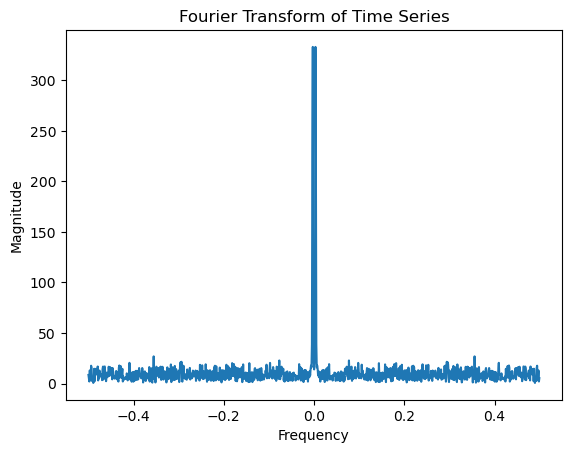

In [56]:
plt.plot(frequencies, jnp.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Fourier Transform of Time Series')
plt.show()

In [57]:
fft_result

Array([ 8.596+0.j   ,  5.329+0.978j,  2.013+0.583j, ..., 11.175+6.711j,
        2.013-0.583j,  5.329-0.978j], dtype=complex64)

In [58]:
import seaborn as sns
import pandas as pd

In [59]:
df = pd.DataFrame({"theta1":thetas_sampled[:, 0], "theta2":thetas_sampled[:, 1]})

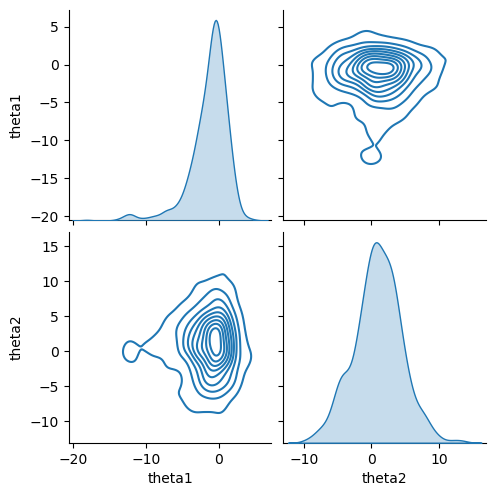

In [60]:
sns.pairplot(df,kind="kde")

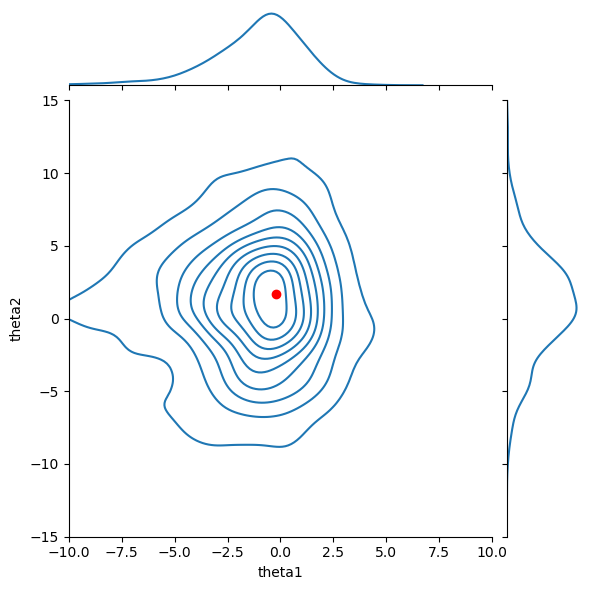

In [61]:
sns.jointplot(data=df,x="theta1", y="theta2", kind="kde", xlim=[-10,10], ylim=[-15,15])
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

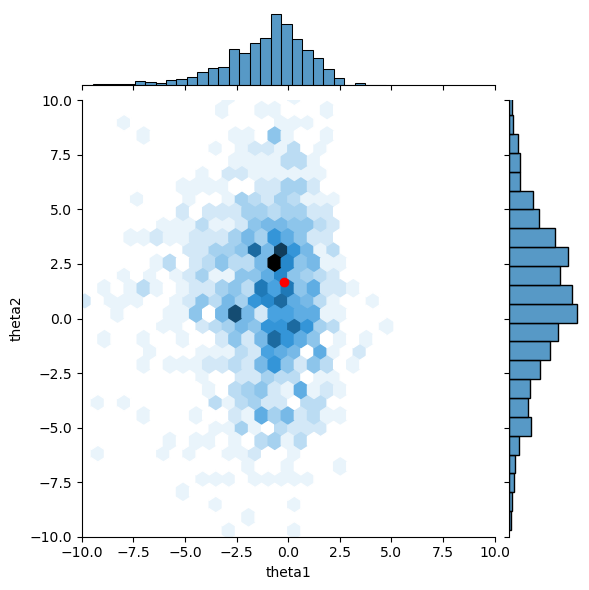

In [62]:
sns.jointplot(data=df,x="theta1", y="theta2", kind="hex", xlim=[-10,10], ylim=[-10,10])
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

In [63]:
import corner

In [64]:
data_ = {"theta1":thetas_sampled[:, 0], "theta2":thetas_sampled[:, 1]}

In [65]:
theta_true

Array([[-0.217,  1.651]], dtype=float32)

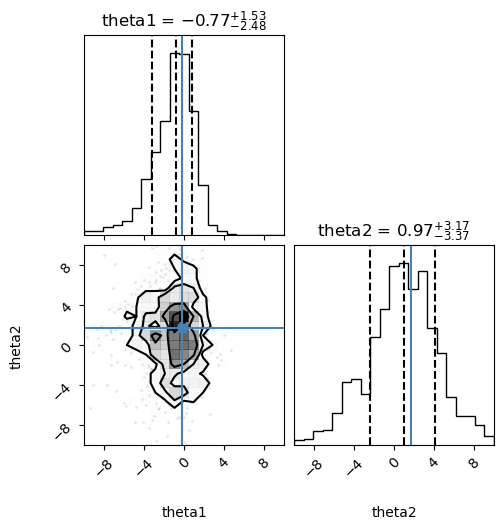

In [66]:
figure = corner.corner(data_, bins=21, range=[[-10,10],[-10,10]],
                       quantiles=[0.16, 0.5, 0.84],show_titles=True,
                       truths=theta_true[0],
                      plot_contours=True,
                      smooth=None)
#axes = np.array(figure.axes).reshape((2, 2))
#axes[1,0].scatter(theta_true[:,0], theta_true[:,1], color="red", zorder=10)
plt.show()

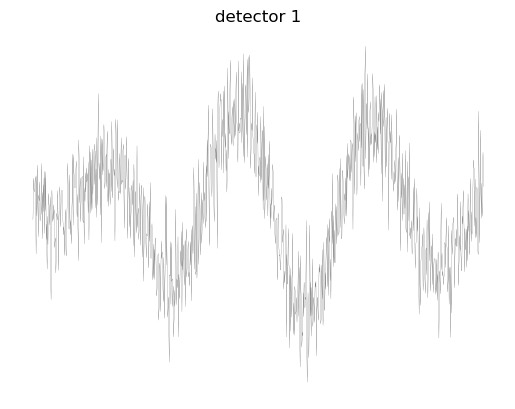

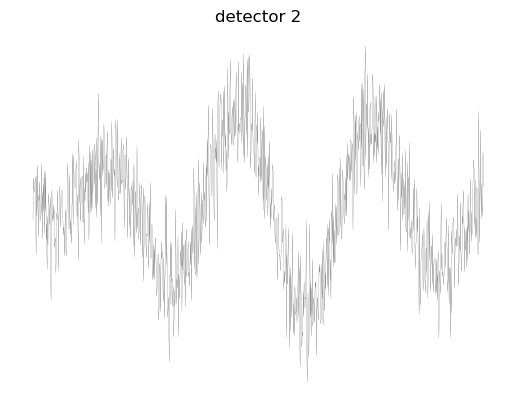

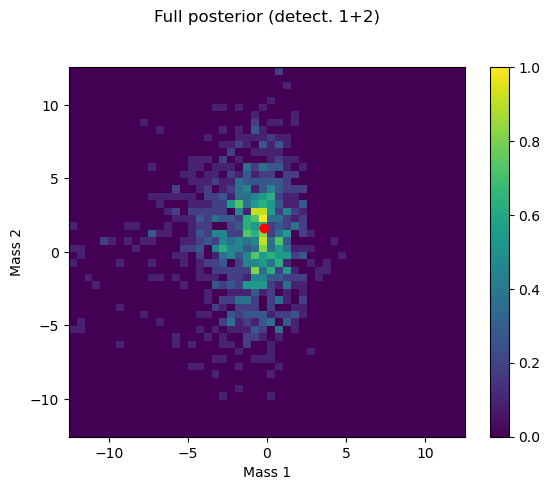

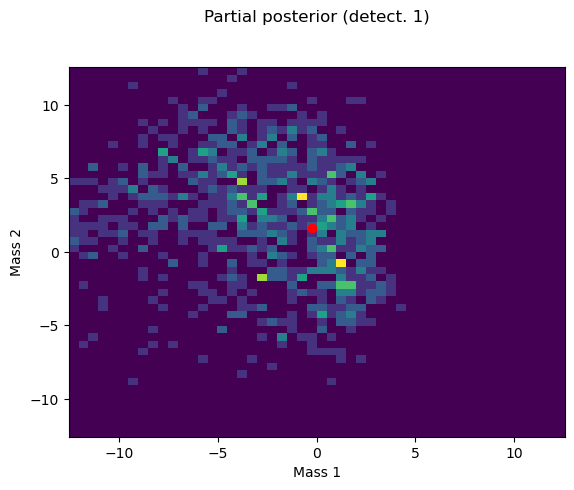

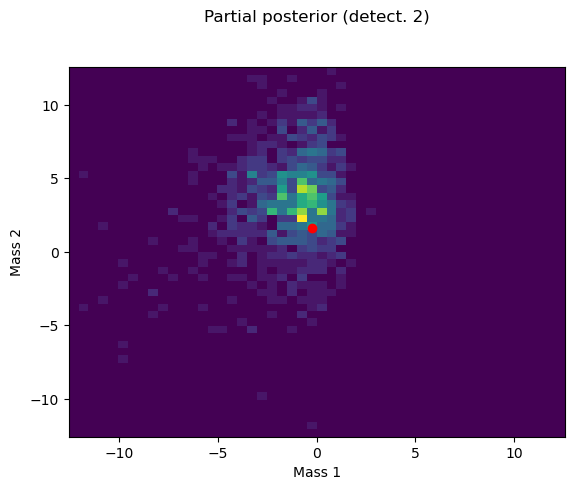

In [67]:
import matplotlib.gridspec as gridspec

# bins1 = np.linspace(-np.pi, np.pi, 101)
# bins2 = np.linspace(0, np.pi, 101)

#xlim = [-1,1]
#ylim=[1.2,2.0]
xlim = [-4*np.pi,4*np.pi]
ylim=[-4*np.pi,4*np.pi]

bins1 = np.linspace(*xlim, 51)
bins2 = np.linspace(*ylim, 51)


plt.plot(x_o_dict["x0"], lw=0.1, color="black")
plt.title("detector 1")
plt.axis("off")
plt.show()

plt.plot(x_o_dict["x1"],lw=0.1, color="black")
plt.title("detector 2")
plt.axis("off")
plt.show()


plt.hist2d(thetas_sampled[:, 0], thetas_sampled[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.colorbar()
# ax1.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.title("Full posterior (detect. 1+2)", y=1.1)
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()


plt.hist2d(thetas_partial1[:, 0], thetas_partial1[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")
plt.title("Partial posterior (detect. 1)", y=1.1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()


plt.hist2d(thetas_partial2[:, 0], thetas_partial2[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")
plt.title("Partial posterior (detect. 2)", y=1.1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()